In [ ]:
#////////////////variables to set/////////////////////////
# /!\
#/_!_\ to change according to computer

#main path to data, change according to environment
root_dir = r'E:\Users\Dylan\Desktop\UdeM_H22\E_PSY3008\data_desmartaux\Nii'
dir_to_save = r'C:\Users\Dylan\Desktop\UdeM_E22\Projet_Ivado_rainvillelab\results_GLM\testing_scripts'

#SERVEUR elm

#root_dir = r'/data/rainville/dylan_projet_ivado_decodage/Nii'
#dir_to_save = r'/data/rainville/dylan_projet_ivado_decodage/results/GLM_1st_level_each_shock'

# /!\
#/_!_\ to change according to computer
#local
timestamps_root_path = r'C:\Users\Dylan\Desktop\BAC_neurocog\UM_H22\PSY3008\times_stamps'

 #elm
#timestamps_path_root = r'/data/rainville/dylan_projet_ivado_decodage/time_stamps'
many_runs=True

In [ ]:
import numpy as np
import os
import pandas as pd
import glob
import nibabel as nib
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
from A_data_prep import function_code as A_data_prep
from B_design_matrix import function_DM as B_design_matrix
from C_contrasts import function_contrasts as contrast

In [ ]:
#==============================================================
#store all subject's name in a list
ls_subj_name = [subject for subject in os.listdir(root_dir)]

#make a list for all the subject's path to data
ls_subj_path  = [os.path.join(root_dir,subject) for subject in os.listdir(root_dir)]


for subj_path in ls_subj_path:

    #=================
    subj_name = os.path.basename(os.path.normpath(subj_path)) #extract last part of subj_path to get subject's name
    print(subj_name + ' = subj_name')
    #----path preparation---
    #res_folder = input('Enter the name under which to create ')
    #Creating a dir to save, only if it doesn't exists
    if os.path.exists(os.path.join(dir_to_save,subj_name)) is False:

        os.mkdir(os.path.join(dir_to_save,subj_name))
    else :
        pass
    #=================
    #looking for the regressors' file, which starts with 'APM' and read it as csv
    movement_reg_name = [i for i in os.listdir(subj_path) if i.startswith('APM')]
    mvmnt_reg_path = os.path.join(subj_path,movement_reg_name[0])#movement_reg_name[0] because there's only one item in the list
    df_mvmnt_reg_full = pd.read_csv(mvmnt_reg_path, sep= '\s+', header=None)#full because we'll split it later according to condition

    #=================
    #file names that contains the fMRI volumes.
    str_analgesia ='Analgesia'
    str_hyper = 'Hyperalgesia'

    if many_runs:
        design_matrices = []
        all_fmri_timeseries = []


In [ ]:
 #Main loop that will go over the condition's file, and generate a design matrix (DM) and a contrast according to the condition
    #In that loop, a Timestamps,a DM name,a mouvement regressors dataframe, a DM and statistical maps will be generated and saved
    for condition_file in [i for i in os.listdir(subj_path) if str_analgesia in i or str_hyper in i ]:
        print(condition_file + ' = condition_file')

        #-------Extracting fMRI volumes-------
        data_path = os.path.join(subj_path,condition_file) #path to the data such as : /subj_01/02-Analgesia/<all nii files>
        subj_volumes= glob.glob(os.path.join(data_path,'sw*'))#extracting all the nii files that start with sw
        print('{} NII files in path {} for subject {}'.format(len(subj_volumes),data_path,subj_name))
        print('lenght of movement regesssor df : {}'.format(len(df_mvmnt_reg_full)))

        #-------Extracting timestamps--------
        timestamps = A_data_prep.get_timestamps(data_path, subj_name,timestamps_root_path,return_df =True)
        timestamps.sort_values(by=['onset'])

        #----condition and design matrix name-----
        condition, DM_name = A_data_prep.if_str_in_file(condition_file,subj_name)#checks if str_analgesia or str_hyper is in condition_file

        #-------movement regessors--------
        if condition == 'HYPO':
             mvmnt_reg_df = A_data_prep.split_reg_upper(df_mvmnt_reg_full,len(subj_volumes))
        elif condition == 'HYPER':
            mvmnt_reg_df = A_data_prep.split_reg_lower(df_mvmnt_reg_full,len(subj_volumes)) #splitting either the first half or lower half of the mvmnt regressor df according to condition (analg/hyper)

        #------DESIGN MATRIX------
        if os.path.exists(os.path.join(dir_to_save, subj_name, DM_name)) is False:#check if the DM already exists in path to we save computing time

            design_matrix, fmri_time_series = B_design_matrix.create_DM(subj_volumes, timestamps, DM_name, mvmnt_reg_df)

            #----------SAVING OUTPUTS------------
            #saving design_matrix and time series
            design_matrix.to_csv(os.path.join(dir_to_save,subj_name,DM_name), index = False)
            fmri_img_name = subj_name + '_' + condition + '_fmri_time_series.nii'
            nib.save(fmri_time_series, os.path.join(dir_to_save,subj_name,fmri_img_name))

        else:
            print('Design matrix in condition _{}_  is already existant for : {} '.format(condition, subj_name))
            design_matrix = pd.read_csv(os.path.join(dir_to_save, subj_name, DM_name))
            fmri_img_name = subj_name + '_' + condition + '_fmri_time_series.nii'
            fmri_time_series = nib.load(os.path.join(dir_to_save,subj_name, fmri_img_name))

        #-------Plot option-------
        #Uncomment to plot the design matrix as it's generated
        #from nilearn.plotting import plot_design_matrix
        #plot_design_matrix(design_matrix)
        #plt.show()

        #-------CONTRAST-------
        done_file_name = 'done_contrast_' + condition + '.txt' #define a done_file name to check if it  already exists in file

        if many_runs: #if many runs, the contrast function is delayed out of this for loop to append the DM and time series for all runs
            design_matrices.append(design_matrix)
            all_fmri_timeseries.append(fmri_time_series)
            condition = 'combined_runs'
        elif os.path.exists(os.path.join(dir_to_save,subj_name,done_file_name)) == False : #if done_file doesn't exist

            #contrast for a single shock activation map
            #beta_map = contrast.glm_contrast_1event(design_matrix, os.path.join(dir_to_save,subj_name), subj_name, fmri_time_series, run = condition)

            #contrast for all shocks activation map, one for each design matrix will be made
            beta_map = contrast.glm_contrast_all_shocks(design_matrix, os.path.join(dir_to_save,subj_name), subj_name, fmri_time_series, run = condition)

            #-------SAVING-------
            #write done_contrast_hyper/hypo to keep track of what has been computed
            save_done_file(os.path.join(dir_to_save,subj_name,done_file_name))

        else:
            print('Contrast : _{}_ has already been done for subject : {} '.format(condition, subj_name))

    if many_runs:

        beta_map = contrast.glm_contrast_runs_N_shocks(design_matrices,all_fmri_timeseries, os.path.join(dir_to_save,subj_name), subj_name, run_name = condition)
        done_file_name = 'done_contrast_' + condition + '.txt'
        contrast.save_done_file(os.path.join(dir_to_save,subj_name,done_file_name))


APM_02_H2 = subj_name
02-Hyperalgesia = condition_file
388 NII files in path E:\Users\Dylan\Desktop\UdeM_H22\E_PSY3008\data_desmartaux\Nii\APM_02_H2\02-Hyperalgesia for subject APM_02_H2
lenght of movement regesssor df : 760
Design matrix in condition _HYPER_  is already existant for : APM_02_H2 
03-Analgesia = condition_file
372 NII files in path E:\Users\Dylan\Desktop\UdeM_H22\E_PSY3008\data_desmartaux\Nii\APM_02_H2\03-Analgesia for subject APM_02_H2
lenght of movement regesssor df : 760
Design matrix in condition _HYPO_  is already existant for : APM_02_H2 
COMPUTING GLM for all the runs, for subject APM_02_H2


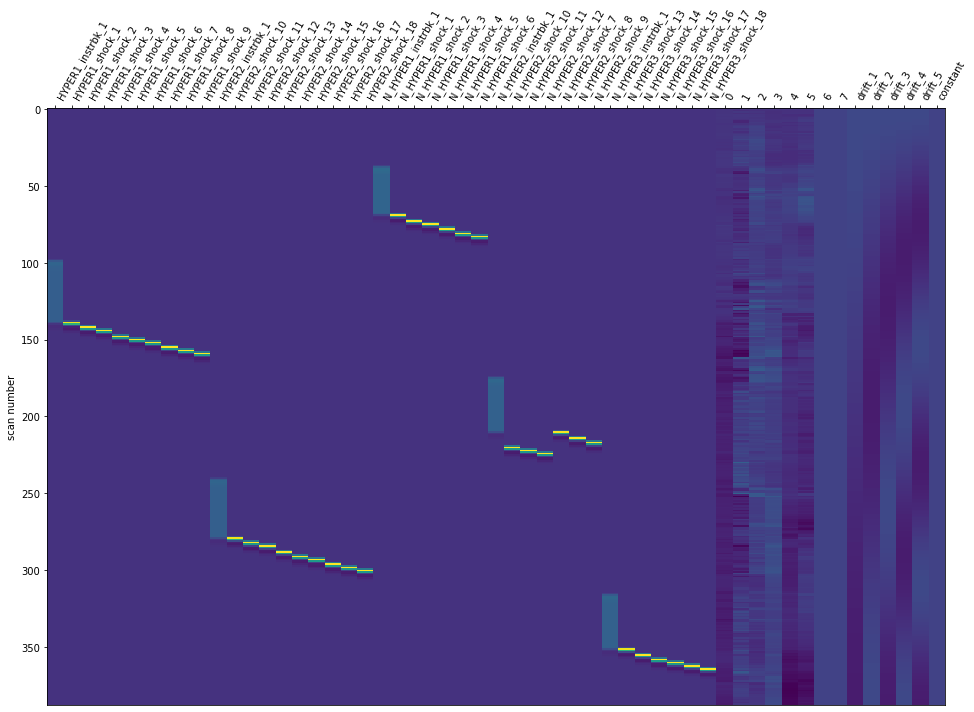

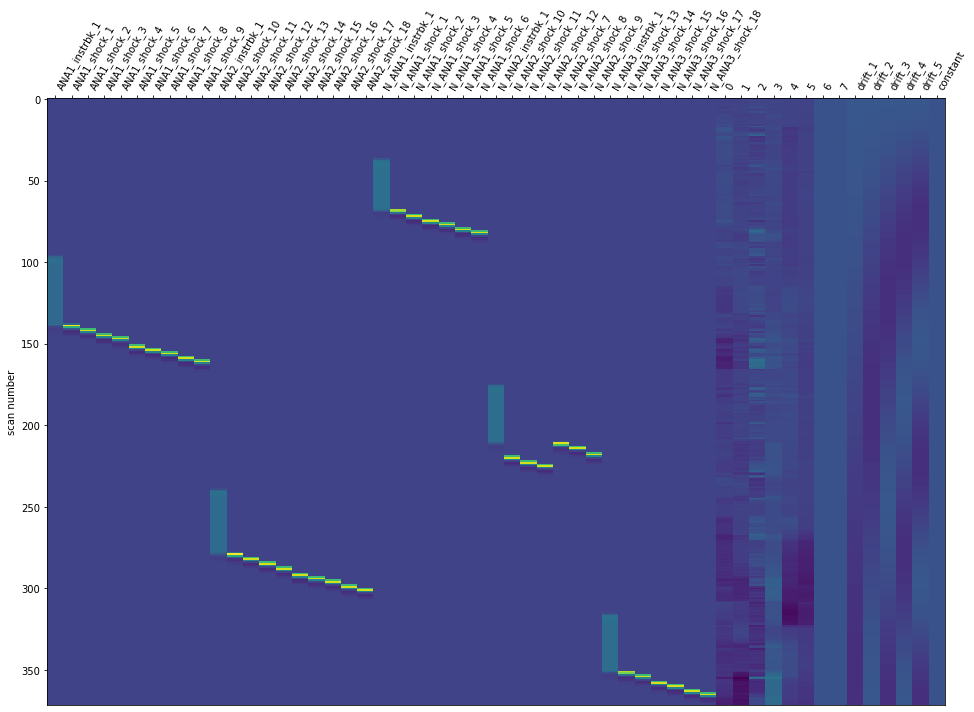

FirstLevelModel(high_pass=0.00233645, hrf_model='spm', t_r=3)
will add  ANA1_shock_1
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_2
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_3
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_4
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_5
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_6
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_7
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_8
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_sho

C:\Users\Dylan\AppData\Roaming\Python\Python310\site-packages\nilearn\glm\first_level\first_level.py:657: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


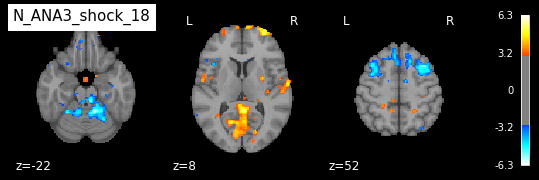

Have saved beta_map as a : <class 'nibabel.nifti1.Nifti1Image'> , having shape : (91, 109, 91) , under name : beta_map_APM_02_H2_combined_runs_Neut_shocks


AttributeError: module 'C_contrasts.function_contrasts' has no attribute 'save_done_file'

In [2]:
import main_script_1st_level

In [9]:
keys = 'N_Ana_shock'

        #if the key is str, in order to exclude the drifts and other parameters
if type(keys) is str:

    ls_string_interest = ['N', 'shock']
    word1 = 'N'
    word2 = 'shock'
    if word1 in keys and word2 in keys:
        print('will add ', keys)
        print('because ls_string_interest[0] is in keys',ls_string_interest[0] in keys)
        print('because ls_string_interest[1] is in keys',ls_string_interest[1] in keys)

    else:
        print('no')#in the contrast vector for all regressors of interest
        

will add  N_Ana_shock
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True


In [ ]:
 actual_key_name = key_list[indx]
                ls_keys.append(keys)#extract the actual regressor/key name with the index position
                contrast_vector += identity_matrix[:, indx] #sum of the contrast vector with the identity matrix column to stack the ones
                 

<div class="alert alert-info">
<h1>Testing two way of computing contrast from Nilearn example </h2>
</div>

## testing multiplecond files from Kunz et al.

### extraire les fichiers .mat et les convrtir en pandas dataframe

In [15]:
import scipy.io
import os

path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\PHASIC\Multiconds_files'

timestamps = scipy.io.loadmat(os.path.join(path, 'KunzStudy1_TxT_cond_pain_block.mat'),simplify_cells =True)
                              

In [17]:
timestamps


{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Apr  7 23:01:24 2017',
 '__version__': '1.0',
 '__globals__': [],
 'names': array(['painbk_1', 'painbk_2', 'painbk_3', 'painbk_4', 'painbk_5',
        'painbk_6', 'painbk_7', 'painbk_8'], dtype=object),
 'onsets': array([31.463, 62.788, 125.438, 219.412, 282.062, 313.406, 376.055,
        471.407], dtype=object),
 'durations': array([10, 10, 10, 10, 10, 10, 10, 10], dtype=object)}

In [18]:
df_timestamps = pd.concat([pd.DataFrame(timestamps['onsets']),pd.DataFrame(timestamps['durations']),pd.DataFrame(timestamps['names'])], axis = 1)
df_timestamps.columns = ['onset', 'duration','trial_type']

## Import SPM design matrices with nilearn

In [2]:
dm_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\TxT_SPM_MAT_Files\APM_02_H2\SPM.mat'

In [6]:
import scipy.io
import os
DM_mat = scipy.io.loadmat(os.path.join(dm_path),simplify_cells =True)

In [7]:
DM_mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Jul  7 15:55:43 2020',
 '__version__': '1.0',
 '__globals__': [],
 'SPM': {'xY': {'RT': 3,
   'P': array(['/Volumes/RainvilleMac_EHD/IMAGING_DATA2/fMRI/ASTREFF/fMRI_Analysis/Model#3/Nii_despiked_subj_artbadvol/diffTS/APM_02_H2/03-Analgesia/swdvraf201212051400-0007-00001-000001-01.nii   ',
          '/Volumes/RainvilleMac_EHD/IMAGING_DATA2/fMRI/ASTREFF/fMRI_Analysis/Model#3/Nii_despiked_subj_artbadvol/diffTS/APM_02_H2/03-Analgesia/swdvraf201212051400-0007-00002-000002-01.nii   ',
          '/Volumes/RainvilleMac_EHD/IMAGING_DATA2/fMRI/ASTREFF/fMRI_Analysis/Model#3/Nii_despiked_subj_artbadvol/diffTS/APM_02_H2/03-Analgesia/swdvraf201212051400-0007-00003-000003-01.nii   ',
          '/Volumes/RainvilleMac_EHD/IMAGING_DATA2/fMRI/ASTREFF/fMRI_Analysis/Model#3/Nii_despiked_subj_artbadvol/diffTS/APM_02_H2/03-Analgesia/swdvraf201212051400-0007-00004-000004-01.nii   ',
          '/Volumes/RainvilleMac_EHD/IMAGING_DATA2/fMRI/

In [6]:
import nipype

In [7]:
import importlib
importlib.reload(nipype)

<module 'nipype' from 'C:\\Users\\Dylan\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\nipype\\__init__.py'>

In [12]:
import nipype.interfaces.spm as spm
est = spm.EstimateModel()
est.inputs.spm_mat_file = dm_path
est.inputs.estimation_method = {'Classical': 1}
est.run()

OSError: This docstring was not generated by Nipype!


## SPM design matrix testing

In [15]:
import pandas as pd
import glob 
from nilearn.image import concat_imgs
import nibabel as nib

In [13]:
import os

# creating saving path for matlab script
    dir = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\TxT_SPM_MAT_Files'
out = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_all_runs'

for folder in os.listdir(dir):
    if 'APM' in folder:
    
        os.mkdir(os.path.join(out,folder))

IndentationError: unexpected indent (742397069.py, line 4)

In [14]:
path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_csv'
save_path = out
nii_path = r'E:\Users\Dylan\Desktop\UdeM_H22\E_PSY3008\data_desmartaux\Nii'


NameError: name 'out' is not defined

In [118]:

for subject in os.listdir(path):
    
    #SPM dm and event extraction
    subj_path = os.path.join(path,subject)
    events = (pd.read_csv(os.path.join(subj_path, os.listdir(subj_path)[1]))) #read event, should change [index] according to folder
    
    csv = pd.read_csv(os.path.join(subj_path, os.listdir(subj_path)[0]))
    print(csv)
    design_matrix= pd.DataFrame()#read DM.csv
    design_matrix.columns = events.columns
    
    #extract and concat fmri data files
    subj_data_path = os.path.join(nii_path,subject)  
    print(subj_data_path)
    subj_volumes = glob.glob(os.path.join(subj_data_path,'*','sw*'))
    print(len(subj_volumes))
    
    fmri_time_series = concat_imgs(subj_volumes)
    #save
    print(design_matrix.shape)
    print(fmri_time_series.shape)
    DM_name = 'DM_SPM_Hyper_Hypo.pkl'
    design_matrix.to_pickle(os.path.join(save_path,subject, DM_name))
    fmri_name = 'fmri_4D_concat_all_runs'
    nib.save(fmri_time_series, os.path.join(save_path,subject,fmri_name))
    print('done saving for ' + subject)

       0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...     0.82      0.83  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00000  0.000000   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00000  0.000000   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00000  0.000000   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00000  0.000000   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00000  0.000000   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...      ...       ...   
754  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.24243  0.032585   
755  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.27500 -0.000676   
756  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.30320  0.012239   
757  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.30802 -0.032072   
758  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.32327  0.047076   

        0.84      0.85     

ValueError: Length mismatch: Expected axis has 0 elements, new values have 100 elements

<AxesSubplot:label='conditions', ylabel='scan number'>

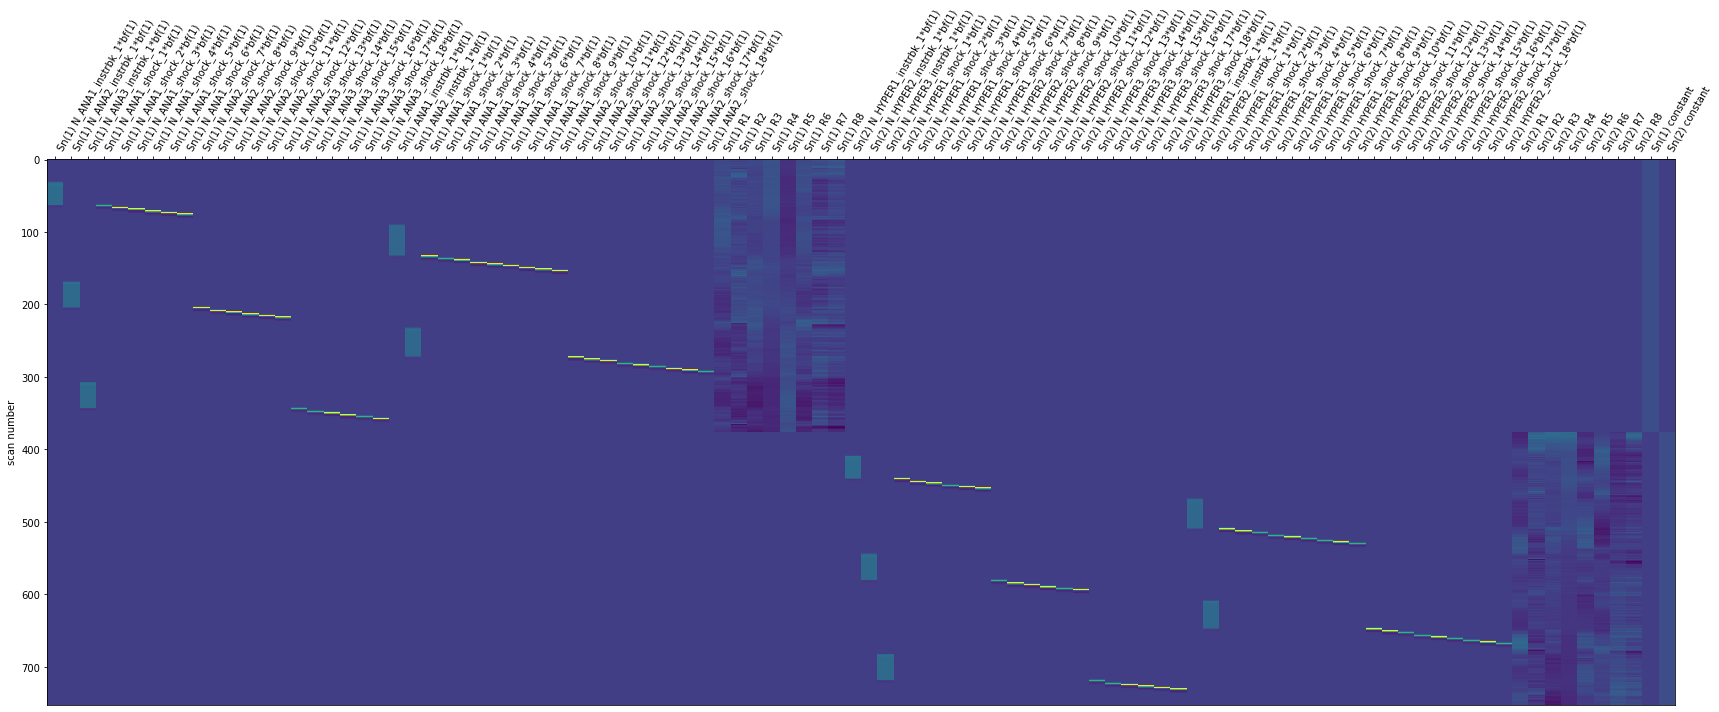

In [45]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)


In [1]:
nii_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_all_runs\APM_02_H2\fmri_4D_concat_all_runs.nii'

In [6]:
import nibabel as nib
imgs = nib.load(nii_path)


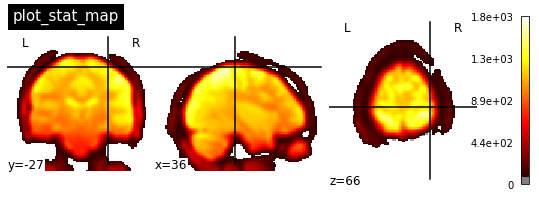

In [11]:
from nilearn import plotting
from nilearn.image import mean_img
# Visualizing t-map image on EPI template with manual
# positioning of coordinates using cut_coords given as a list
plotting.plot_stat_map(mean_img(imgs),
                       threshold=100, title="plot_stat_map",
                       cut_coords=[36, -27, 66])

In [8]:
def load_pkl_to_pd(ls_pkl_paths):
    #--load design matrices from pkl to pandas-----
    ls_pandas = []
    for i in range(len(ls_pkl_paths)):
        tmp = pd.read_pickle(ls_pkl_paths[i])
        ls_pandas.append(tmp)

    return ls_pandas

In [28]:
subj_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_all_runs\APM_02_H2\DM_SPM_Hyper_Hypo.csv'
#events = (pd.read_csv(os.path.join(subj_path, os.listdir(subj_path)[1]))) #read event, should change [index] according to folder
import os   
csv = pd.read_csv(subj_path,index_col = 1)
csv

Unnamed: 0  Sn(1) N_ANA1_instrbk_1*bf(1)  Sn(1) N_ANA2_instrbk_1*bf(1)  \
0             0                           0.0                           0.0   
1             1                           0.0                           0.0   
2             2                           0.0                           0.0   
3             3                           0.0                           0.0   
4             4                           0.0                           0.0   
..          ...                           ...                           ...   
755         755                           0.0                           0.0   
756         756                           0.0                           0.0   
757         757                           0.0                           0.0   
758         758                           0.0                           0.0   
759         759                           0.0                           0.0   

     Sn(1) N_ANA3_instrbk_1*bf(1)  Sn(1) N_ANA1_shock_1*bf(1)  \
0                             0.0                         0.0   
1                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
..                            ...                         ...   
755                           0.0                         0.0   
756                           0.0                         0.0   
757                           0.0                         0.0   
758                           0.0                         0.0   
759                           0.0                         0.0   

     Sn(1) N_ANA1_shock_2*bf(1)  Sn(1) N_ANA1_shock_3*bf(1)  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
..                          ...                         ...   
755                         0.0                         0.0   
756                         0.0                         0.0   
757                         0.0                         0.0   
758                         0.0                         0.0   
759                         0.0                         0.0   

     Sn(1) N_ANA1_shock_4*bf(1)  Sn(1) N_ANA1_shock_5*bf(1)  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
..                          ...                         ...   
755                         0.0                         0.0   
756                         0.0                         0.0   
757                         0.0                         0.0   
758                         0.0                         0.0   
759                         0.0                         0.0   

     Sn(1) N_ANA1_shock_6*bf(1)  ...  Sn(2) R1  Sn(2) R2  Sn(2) R3  Sn(2) R4  \
0                           0.0  ...  0.000000  0.000000  0.000000  0.000000   
1                           0.0  ...  0.000000  0.000000  0.000000  0.000000   
2                           0.0  ...  0.000000  0.000000  0.000000  0.000000   
3                           0.0  ...  0.000000  0.000000  0.000000  0.000000   
4                           0.0  ...  0.000000  0.000000  0.000000  0.000000   
..                          ...  ...       ...       ...       ...       ...   
755                         0.0  ... -0.242426  0.032585 -0.504466  0.006033   
756                         0.0  ... -0.274999 -0.000676 -0.522118  0.007163   
757                         0.0  ... -0.3

### Testing GLM 

In [11]:
import os
pkl_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_all_runs'
subj_name = r'APM_03_H1'
paths_design_matrices = glob.glob(os.path.join(pkl_path, subj_name,'DM*pkl'))
print(paths_design_matrices)
design_matrices = load_pkl_to_pd(paths_design_matrices)
design_matrices[0]


['C:\\Users\\Dylan\\Desktop\\UM_Bsc_neurocog\\E22\\Projet_Ivado_rainvillelab\\results_GLM\\SPM_DM_single_event_all_runs\\APM_03_H1\\DM_SPM_Hyper_Hypo.pkl']


Sn(1) N_ANA1_instrbk_1*bf(1)  Sn(1) N_ANA2_instrbk_1*bf(1)  \
0                             0.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             0.0                           0.0   
4                             0.0                           0.0   
..                            ...                           ...   
739                           0.0                           0.0   
740                           0.0                           0.0   
741                           0.0                           0.0   
742                           0.0                           0.0   
743                           0.0                           0.0   

     Sn(1) N_ANA3_instrbk_1*bf(1)  Sn(1) N_ANA1_shock_1*bf(1)  \
0                             0.0                         0.0   
1                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
..                            ...                         ...   
739                           0.0                         0.0   
740                           0.0                         0.0   
741                           0.0                         0.0   
742                           0.0                         0.0   
743                           0.0                         0.0   

     Sn(1) N_ANA1_shock_2*bf(1)  Sn(1) N_ANA1_shock_3*bf(1)  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
..                          ...                         ...   
739                         0.0                         0.0   
740                         0.0                         0.0   
741                         0.0                         0.0   
742                         0.0                         0.0   
743                         0.0                         0.0   

     Sn(1) N_ANA1_shock_4*bf(1)  Sn(1) N_ANA1_shock_5*bf(1)  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
..                          ...                         ...   
739                         0.0                         0.0   
740                         0.0                         0.0   
741                         0.0                         0.0   
742                         0.0                         0.0   
743                         0.0                         0.0   

     Sn(1) N_ANA1_shock_6*bf(1)  Sn(1) N_ANA2_shock_7*bf(1)  ...  Sn(2) R1  \
0                           0.0                         0.0  ...  0.000000   
1                           0.0                         0.0  ...  0.000000   
2                           0.0                         0.0  ...  0.000000   
3                           0.0                         0.0  ...  0.000000   
4                           0.0                         0.0  ...  0.000000   
..                          ...                         ...  ...       ...   
739                         0.0                         0.0  ...  0.039385   
740                         0.0                         0.0  ...  0.033708   
741                         0.0                         0.0  ...  0.047123   
742                         0.0                         0.0  ...  0.054893   
743                         0.0                

In [12]:
paths_img = glob.glob(os.path.join(pkl_path, subj_name,'fmri*'))
paths_img

['C:\\Users\\Dylan\\Desktop\\UM_Bsc_neurocog\\E22\\Projet_Ivado_rainvillelab\\results_GLM\\SPM_DM_single_event_all_runs\\APM_03_H1\\fmri_4D_concat_all_runs.nii']

In [13]:
imgs = nib.load(paths_img[0])
imgs.shape

(91, 109, 91, 744)

In [14]:
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs, mean_img
import nibabel as nib
from nilearn.plotting import plot_design_matrix
fmri_glm = FirstLevelModel(t_r=3,
                               noise_model='ar1',
                               standardize=False,
                               slice_time_ref = 0.5,
                               hrf_model='spm',
                               drift_model='cosine',
                               high_pass= 0.00233645)

In [ ]:
fmri_glm.fit(paths_img, design_matrices = design_matrices[0])

In [ ]:
contrast_vector = []
beta_map = fmri_glm.compute_contrast(
         contrast_vector, stat_type = 't', output_type= output_type)

In [ ]:
for subject in os.listdir(path):
    
    #SPM dm and event extraction
    subj_path = os.path.join(path,subject)
    
    
    
    +v = pd.read_csv(os.path.join(subj_path, os.listdir(subj_path)[0]))
    print(csv)
    design_matrix= pd.DataFrame()#read DM.csv
    design_matrix.columns = events.columns
    
    #extract and concat fmri data files
    subj_data_path = os.path.join(nii_path,subject)  
    print(subj_data_path)
    subj_volumes = glob.glob(os.path.join(subj_data_path,'*','sw*'))
    print(len(subj_volumes))
    
    
    
    
    
    